Populating the interactive namespace from numpy and matplotlib
Cu_orbs =  ['d3z2r2', 'dx2y2', 'dxy', 'dxz', 'dyz']
O1_orbs =  ['px']
O2_orbs =  ['py']
symmetries =  ['1A1', '1B1', '3B1']
E_1S =  12.66
E_1G =  8.26
E_1D =  7.21
E_3P =  7.55
E_3F =  5.3
Mc= 20
VS.dim =  327645
No. of states with count_upup, count_updn, count_dnup, count_dndn: 81810 82225 81800 81810
start create_tpd_nn_matrix
start create_tpp_nn_matrix
start create_edep_diag_matrix
len(d_list) 45 Nd= 45
start computing A_dd(w) for sym 1A1
orbitals in sym  1A1 =  [('dyz', 'dyz'), ('dxz', 'dxz'), ('dxy', 'dxy'), ('d3z2r2', 'd3z2r2'), ('dx2y2', 'dx2y2')]
dd_state_indices 83808 , state: S=  0  Sz=  1 orb=  dx2y2 dx2y2
lowest eigenvalue of H =  [-2.19466319 -2.19466319 -2.19466319 -2.19466319 -1.74250366 -1.74250366
 -1.74250366 -1.74250366 -1.74250366 -1.74250366 -1.74250366 -1.74250366
 -1.74250366 -1.74250366 -1.74250366 -1.74250366 -1.6847513  -0.59874421
 -0.59874421 -0.59874421]
eigenvalue =  -2.1946631914931203
Compute

state  py 0 -1 dyz 0 0 S= 1 Sz= 0 , weight =  0.0033686469198656982
state  py 0 -1 dyz 0 0 S= 0 Sz= 1 , weight =  0.010576553821689209
state  dxy 0 0 dx2y2 0 0 S= 0 Sz= 1 , weight =  0.046818379871317754
state  dxz 0 0 dx2y2 0 0 S= 0 Sz= 1 , weight =  0.008050879078901202
state  dyz 0 0 dx2y2 0 0 S= 0 Sz= 1 , weight =  0.09418971312561882
state  dx2y2 0 0 dxy 0 0 S= 1 Sz= 0 , weight =  0.16938809437156294
state  dx2y2 0 0 dxy 0 0 S= 1 Sz= 1 , weight =  0.012504603264523594
state  dx2y2 0 0 dxy 0 0 S= 1 Sz= 2 , weight =  0.04055628105165469
state  dx2y2 0 0 dxz 0 0 S= 1 Sz= 0 , weight =  0.015585405117519295
state  dx2y2 0 0 dxz 0 0 S= 1 Sz= 1 , weight =  0.22291996522043486
state  dx2y2 0 0 dxz 0 0 S= 1 Sz= 2 , weight =  0.030151493835677223
state  dx2y2 0 0 dyz 0 0 S= 1 Sz= 0 , weight =  0.029999553006857752
state  dx2y2 0 0 dyz 0 0 S= 1 Sz= 2 , weight =  0.011696406211656225
state  dxy 0 0 py 0 1 S= 1 Sz= 0 , weight =  0.01902057281440979
state  dxy 0 0 py 0 1 S= 0 Sz= 1 , weight =  

state  dxz 0 0 px 1 0 S= 0 Sz= 1 , weight =  0.003531105172310129
state  dxz 0 0 px 1 0 S= 1 Sz= 1 , weight =  0.010550064842487975
eigenvalue =  -1.7425036578339186
Compute the weights in GS (lowest Aw peak)
state  px -1 0 dxy 0 0 S= 0 Sz= 1 , weight =  0.010226193420025046
state  px -1 0 dxy 0 0 S= 1 Sz= 1 , weight =  0.0073325425913338274
state  px -1 0 dxy 0 0 S= 1 Sz= 2 , weight =  0.007001092086542805
state  px -1 0 dxz 0 0 S= 1 Sz= 0 , weight =  0.01683120884218074
state  px -1 0 dxz 0 0 S= 1 Sz= 2 , weight =  0.016002323928938446
state  px -1 0 dyz 0 0 S= 1 Sz= 0 , weight =  0.009667906319484183
state  py 0 -1 dxy 0 0 S= 0 Sz= 1 , weight =  0.010226193420025027
state  py 0 -1 dxy 0 0 S= 1 Sz= 1 , weight =  0.0073325425913338205
state  py 0 -1 dxy 0 0 S= 1 Sz= 2 , weight =  0.007001092086542805
state  py 0 -1 dxz 0 0 S= 1 Sz= 0 , weight =  0.01683120884218073
state  py 0 -1 dxz 0 0 S= 1 Sz= 2 , weight =  0.01600232392893841
state  py 0 -1 dyz 0 0 S= 1 Sz= 0 , weight =  0.0096679

state  dx2y2 0 0 px 3 -6 S= 1 Sz= 1 , weight =  0.0035195735541108364
state  dx2y2 0 0 px 3 -4 S= 1 Sz= 1 , weight =  0.0032661147318242875
state  dx2y2 0 0 px 3 4 S= 1 Sz= 1 , weight =  0.0032661147318244215
state  dx2y2 0 0 px 3 6 S= 1 Sz= 1 , weight =  0.0035195735541110286
state  dx2y2 0 0 px 3 8 S= 1 Sz= 1 , weight =  0.003047258958989624
state  dx2y2 0 0 py 4 -7 S= 1 Sz= 1 , weight =  0.003146800239135471
state  dx2y2 0 0 py 4 -5 S= 1 Sz= 1 , weight =  0.0034868604387717703
state  dx2y2 0 0 py 4 -3 S= 1 Sz= 1 , weight =  0.0032661147318243334
state  dx2y2 0 0 py 4 -1 S= 1 Sz= 1 , weight =  0.0028891394628961548
state  dx2y2 0 0 py 4 1 S= 1 Sz= 1 , weight =  0.002889139462896185
state  dx2y2 0 0 py 4 3 S= 1 Sz= 1 , weight =  0.003266114731824413
state  dx2y2 0 0 py 4 5 S= 1 Sz= 1 , weight =  0.0034868604387719147
state  dx2y2 0 0 py 4 7 S= 1 Sz= 1 , weight =  0.003146800239135644
state  dx2y2 0 0 px 5 -6 S= 1 Sz= 1 , weight =  0.003178918978817937
state  dx2y2 0 0 px 5 -4 S= 1 Sz=

w_lowpeak =  -1.6847500000012832
peak w-range = [ -1.836750000001199 -1.5327500000013674 ]
peak, weight =  -1.6847500000012832    0.07187582009076478
start computing A_dd(w) for sym 1B1
orbitals in sym  1B1 =  [('d3z2r2', 'dx2y2'), ('dxz', 'dxz'), ('dyz', 'dyz')]
dd_state_indices 83801 , state: S=  0  Sz=  1 orb=  dx2y2 d3z2r2
lowest eigenvalue of H =  [-3.48500732 -2.19466319 -2.19466319 -2.19466319 -1.74250366 -1.74250366
 -1.74250366 -1.74250366 -1.74250366 -1.74250366 -1.74250366 -1.74250366
 -1.74250366 -1.74250366 -1.74250366 -1.74250366 -0.90431907 -0.59874421
 -0.59874421 -0.59874421]
eigenvalue =  -3.4850073156678434
Compute the weights in GS (lowest Aw peak)
state  px -1 0 px -1 0 S= 0 Sz= 1 , weight =  0.005862400590428363
state  px -1 0 py 0 -1 S= 0 Sz= 1 , weight =  0.011724801180856729
state  py 0 -1 py 0 -1 S= 0 Sz= 1 , weight =  0.005862400590428363
state  px -1 0 dx2y2 0 0 S= 0 Sz= 1 , weight =  0.10441545311433326
state  py 0 -1 dx2y2 0 0 S= 0 Sz= 1 , weight =  0.1044

state  dxy 0 0 py 0 1 S= 1 Sz= 0 , weight =  0.0110356409546508
state  dxz 0 0 py 0 1 S= 1 Sz= 0 , weight =  0.007903071776378511
state  dxz 0 0 py 0 1 S= 0 Sz= 1 , weight =  0.004184625660979769
state  dxz 0 0 py 0 1 S= 1 Sz= 1 , weight =  0.030416807363368287
state  dyz 0 0 py 0 1 S= 0 Sz= 1 , weight =  0.010065718972110217
state  dyz 0 0 py 0 1 S= 1 Sz= 1 , weight =  0.010007061744646944
state  dxy 0 0 px 1 0 S= 1 Sz= 0 , weight =  0.011035640954650797
state  dxz 0 0 px 1 0 S= 1 Sz= 0 , weight =  0.007903071776378511
state  dxz 0 0 px 1 0 S= 0 Sz= 1 , weight =  0.004184625660979784
state  dxz 0 0 px 1 0 S= 1 Sz= 1 , weight =  0.030416807363368298
state  dyz 0 0 px 1 0 S= 0 Sz= 1 , weight =  0.01006571897211022
state  dyz 0 0 px 1 0 S= 1 Sz= 1 , weight =  0.010007061744646948
eigenvalue =  -1.7425036578339255
Compute the weights in GS (lowest Aw peak)
state  px -1 0 dxy 0 0 S= 1 Sz= 0 , weight =  0.0035016406061890715
state  px -1 0 dxy 0 0 S= 1 Sz= 1 , weight =  0.00783502903814127


w_lowpeak =  0.126499999997713
peak w-range = [ 0.04674999999775764 0.1614999999976936 ]
peak, weight =  0.126499999997713    0.06245262587483052
start computing A_dd(w) for sym 3B1
orbitals in sym  3B1 =  [('d3z2r2', 'dx2y2')]
dd_state_indices 83805 , state: S=  1  Sz=  0 orb=  d3z2r2 dx2y2
dd_state_indices 83806 , state: S=  1  Sz=  1 orb=  d3z2r2 dx2y2
dd_state_indices 83807 , state: S=  1  Sz=  2 orb=  d3z2r2 dx2y2
lowest eigenvalue of H =  [-3.48500732 -2.19466319 -1.74250366 -1.74250366 -1.74250366 -1.74250366
 -1.74250366 -1.74250366 -1.74250366 -1.74250366 -1.74250366 -1.74250366
 -1.74250366 -1.74250366 -0.90431907 -0.59874421 -0.59874421 -0.59874421
 -0.59874421 -0.57578802]
eigenvalue =  -3.485007315667854
Compute the weights in GS (lowest Aw peak)
state  px -1 0 px -1 0 S= 0 Sz= 1 , weight =  0.005862400590428342
state  px -1 0 py 0 -1 S= 0 Sz= 1 , weight =  0.011724801180856701
state  py 0 -1 py 0 -1 S= 0 Sz= 1 , weight =  0.005862400590428346
state  px -1 0 dx2y2 0 0 S= 0

state  dx2y2 0 0 dyz 0 0 S= 1 Sz= 1 , weight =  0.06341618455185523
state  dxy 0 0 py 0 1 S= 0 Sz= 1 , weight =  0.004114658742326861
state  dxy 0 0 py 0 1 S= 1 Sz= 1 , weight =  0.04080503733661864
state  dxz 0 0 py 0 1 S= 1 Sz= 0 , weight =  0.020338269771730245
state  dyz 0 0 py 0 1 S= 1 Sz= 1 , weight =  0.007120997259906084
state  dxy 0 0 px 1 0 S= 0 Sz= 1 , weight =  0.004114658742326861
state  dxy 0 0 px 1 0 S= 1 Sz= 1 , weight =  0.0408050373366187
state  dxz 0 0 px 1 0 S= 1 Sz= 0 , weight =  0.02033826977173026
state  dyz 0 0 px 1 0 S= 1 Sz= 1 , weight =  0.007120997259906084
eigenvalue =  -1.7425036578339232
Compute the weights in GS (lowest Aw peak)
state  px -1 0 dxy 0 0 S= 1 Sz= 1 , weight =  0.0030795052200346703
state  px -1 0 dxy 0 0 S= 1 Sz= 2 , weight =  0.004161562436047434
state  px -1 0 dxz 0 0 S= 1 Sz= 0 , weight =  0.017722082145593263
state  px -1 0 dxz 0 0 S= 0 Sz= 1 , weight =  0.010534440057267409
state  px -1 0 dxz 0 0 S= 1 Sz= 2 , weight =  0.01749030438268

state  py -2 7 dx2y2 0 0 S= 0 Sz= 1 , weight =  0.002760491948162553
state  px -1 -8 dx2y2 0 0 S= 0 Sz= 1 , weight =  0.0026426846123666628
state  px -1 -6 dx2y2 0 0 S= 0 Sz= 1 , weight =  0.002840089312735597
state  px -1 6 dx2y2 0 0 S= 0 Sz= 1 , weight =  0.0028400893127356304
state  px -1 8 dx2y2 0 0 S= 0 Sz= 1 , weight =  0.0026426846123667
state  py 0 -7 dx2y2 0 0 S= 0 Sz= 1 , weight =  0.0028433103301495283
state  py 0 -5 dx2y2 0 0 S= 0 Sz= 1 , weight =  0.0026417474040273553
state  dx2y2 0 0 py 0 5 S= 0 Sz= 1 , weight =  0.002641747404027375
state  dx2y2 0 0 py 0 7 S= 0 Sz= 1 , weight =  0.002843310330149546
state  dx2y2 0 0 px 1 -8 S= 0 Sz= 1 , weight =  0.002642684612366675
state  dx2y2 0 0 px 1 -6 S= 0 Sz= 1 , weight =  0.002840089312735622
state  dx2y2 0 0 px 1 6 S= 0 Sz= 1 , weight =  0.0028400893127356183
state  dx2y2 0 0 px 1 8 S= 0 Sz= 1 , weight =  0.0026426846123666784
state  dx2y2 0 0 py 2 -7 S= 0 Sz= 1 , weight =  0.0027604919481625484
state  dx2y2 0 0 py 2 -5 S= 0 S

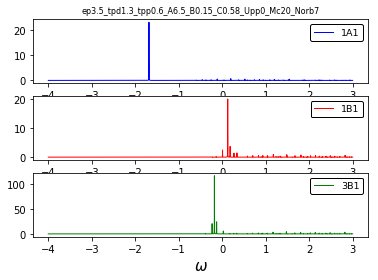

In [1]:
%pylab inline

import math
import numpy as np
from scipy.sparse.linalg import inv
#from numpy.linalg import inv
import scipy.sparse as sps
import scipy.sparse.linalg
from scipy import integrate
import sys
import matplotlib.pyplot as plt
sys.path.append('../../src/')
from pylab import *

import parameters as pam
import lattice as lat
import variational_space as vs
import hamiltonian as ham
import basis_change as basis
import lanczos

M_PI = math.pi
Mc  = pam.Mc
print 'Mc=',Mc

w_vals = pam.w_vals
Norb = pam.Norb
eta = pam.eta
ed  = pam.ed
ep  = pam.ep

if Norb==3 or Norb==7:
    tpd = pam.tpd
    tpp = pam.tpp
elif Norb==9:
    pds = pam.pds
    pdp = pam.pdp
    pps = pam.pps
    ppp = pam.ppp
    
Upp = pam.Upp
if Norb==3:
    Udd = pam.Udd
elif Norb==7 or Norb==9:
    A = pam.A
    B = pam.B
    C = pam.C
                    
if Norb==3:
    fname = 'ep'+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp)+ \
            '_Udd'+str(Udd)+'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_Norb'+str(Norb)
elif Norb==7:
    fname = 'ep'+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp) \
          +'_A'+str(A)+'_B'+str(B)+'_C'+str(C) \
          +'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_Norb'+str(Norb)
elif Norb==9:
    fname = 'ep'+str(ep)+'_pds'+str(pds)+'_pdp'+str(pdp)+'_pps'+str(pps)+'_ppp'+str(ppp) \
          +'_A'+str(A)+'_B'+str(B)+'_C'+str(C) \
          +'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_Norb'+str(Norb)
                        
Ms = ['-b','-r','-g','-m','-c','-k','-y','--b','--r','--g','--m','--c','--k','--y',\
      '-.b','-.r','-.g','-.m','-.c','-.k','-.y',':b',':r',':g',':m',':c',':k',':y']
#####################################
def writefile(fname,state,Aw):
    f = open(fname,'w',1) # line buffering

    # Print header into file
    f.write('#Mc\t{:.6f}\n'.format(Mc))
    f.write('#tpd\t{:.6f}\n'.format(tpd))
    f.write('#tpp\t{:.6f}\n'.format(tpp))
    f.write('#ed\t{:.6f}\n'.format(ed))
    f.write('#ep\t{:.6f}\n'.format(ep))
    f.write('#Upp\t{:.6f}\n'.format(Upp))
    f.write('#eta\t{:.6f}\n'.format(eta))
    f.write('#state_pairs = \t\n')
    f.write(str(state)+'\n')
    f.write('#omega\tspectral weight\n')
    
    for i in xrange(0,len(w_vals)):
        f.write('{:.6e}\t{:.6e}\n'.format(float(w_vals[i]),Aw[i]))
    
def getAw(matrix,index,VS,w_vals):  
    # set up Lanczos solver
    dim  = VS.dim
    scratch = np.empty(dim, dtype = complex)
    Phi0 = np.zeros(dim, dtype = complex)
    Phi0[index] = 1.0
    solver = lanczos.LanczosSolver(maxiter = pam.Lanczos_maxiter, 
                                   precision = 1e-12, 
                                   cond = 'UPTOMAX', 
                                   eps = 1e-8)
    solver.first_pass(x0 = Phi0, scratch = scratch, H = matrix)
    V, D = solver.lanczos_diag_T()

    # D[0,:] is the eigenvector for lowest eigenvalue
    tab = np.abs(D[0,:])**2

    Aw = np.zeros(len(w_vals))
    for n in range(len(V)):
        Aw += tab[n] * eta / M_PI * ( (w_vals - V[n])**2 + eta**2)**(-1)
        
    w_peak, weight = getAw_peak_pos_weight(Aw, D, tab)
    return Aw# w_peak, weight

def getAw_peak_pos_weight(Aw, D, tab):  
    '''
    find the position and weight of lowest peak of Aw
    used to explore their dispersion in the high symmetry points in BZ
    '''    
    w_idx = np.argmax(Aw)
    w_peak = w_vals[w_idx]
    print 'w_lowpeak = ', w_peak
    
    # find the area below the whole peak, namely the peak weight
    # ==========================================================
    # 1. first find the peak's w-range: [w_min, w_max]
    wid = w_idx
    while Aw[wid]>1.e-3:
        #print w_vals[wid], Aw[wid]
        if Aw[wid-1]>Aw[wid]:
            break
        wid -= 1
    w_min = wid
    
    wid = w_idx
    while Aw[wid]>1.e-3:
        #print w_vals[wid], Aw[wid]
        if Aw[wid+1]>Aw[wid]:
            break
        wid += 1
    w_max = wid
    
    print 'peak w-range = [', w_vals[w_min], w_vals[w_max], ']'
    
    # 2. Simpson's rule
    weight = integrate.simps(Aw[w_min:w_max], w_vals[w_min:w_max])
    print 'peak, weight = ', w_peak, '  ', weight
                          
    '''
    # find the eigenvalue D[n] nearest to w_peak so that its index n
    # leads to weight = tab[n]; Note that this weight is actually for 
    # the single peak instead of the area below the whole peak
    tmp = []
    for n in range(len(D)):
        tmp.append(abs(D[n]-w_peak))
        
    idx = tmp.index(min(tmp))
    weight = tab[idx]
    assert(weight>=0.0 and weight<=1.0)
    '''
    return w_peak, weight

def get_ground_state(matrix,S_val,Sz_val):  
    '''
    Obtain the ground state info, namely the lowest peak in Aw_dd's component
    in particular how much weight of various d8 channels: a1^2, b1^2, b2^2, e^2
    
    Note that if Aw has a lowest single peak, then its energy should equal E0
    '''        
    Neval = 20
    vals, vecs = sps.linalg.eigsh(matrix, k=Neval, which='SA')
    print 'lowest eigenvalue of H = ', vals
    
    # get state components in GS and another 9 higher states; note that indices is a tuple
    for k in xrange(0,Neval):
        print 'eigenvalue = ', vals[k]
        indices = np.nonzero(abs(vecs[:,k])>0.05)

        print "Compute the weights in GS (lowest Aw peak)"
        for i in indices[0]:
            # now the basis is after basis change, namely singlets/triplets
            # but its orbital info remains the same as original states
            state = VS.get_state(VS.lookup_tbl[i])
            s1 = state['hole1_spin']
            s2 = state['hole2_spin']
            o1 = state['hole1_orb']
            o2 = state['hole2_orb']
            x1, y1 = state['hole1_coord']
            x2, y2 = state['hole2_coord']

            # also obtain the total S and Sz of the state
            S12  = S_val[i]
            Sz12 = Sz_val[i]

            print 'state ', o1,x1,y1,o2,x2,y2, 'S=',S12,'Sz=',Sz12, \
                  ", weight = ", abs(vecs[i,k])**2
    return vals, vecs

def plot_atomic_multiplet_peaks(data_for_maxval):
    maxval = max(data_for_maxval)
    yy = [0,maxval]
    xx = [pam.E_1S,pam.E_1S]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_1S-0.2, 10.2, 'E_1S', fontsize=5)
    xx = [pam.E_1G,pam.E_1G]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_1G-0.2, 10.5, 'E_1G', fontsize=5)
    xx = [pam.E_1D,pam.E_1D]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_1D-0.2, 10.8, 'E_1D', fontsize=5)
    xx = [pam.E_3P,pam.E_3P]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_3P-0.2, 11.1, 'E_3P', fontsize=5)
    xx = [pam.E_3F,pam.E_3F]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_3F-0.2, 11.4, 'E_3F', fontsize=5)
            
def compute_Aw(pam_flag,ham_func,fig_name):
    if pam_flag == 1:
        state_indices = ham_func(VS)
        print "===================================="
        clf()
        Nstate = len(state_indices)
        for j in range(0,Nstate):
            index = state_indices[j]
            Aw = getAw(H,index,VS,w_vals)           

            state = VS.get_state(VS.lookup_tbl[index])
            s1 = state['hole1_spin']
            s2 = state['hole2_spin']
            o1 = state['hole1_orb']
            o2 = state['hole2_orb']
            #subplot(Nstate,1,j+1)
            plt.plot(w_vals, Aw, Ms[j], linewidth=1, label=tuple([s1,o1,s2,o2]))

            maxval = max(Aw)
            #xlim([-5,20])
            xlim([0,15])
            #ylim([0,maxval])
            ylim([0,0.5])
            #ylabel('$A(\omega)$',fontsize=14)
            #text(0.45, 0.1, '(a)', fontsize=16)
            grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
            legend(loc='best', fontsize=6.5, framealpha=1.0, edgecolor='black')
            if j==0:
                title(fname, fontsize=8)
            if j==Nstate-1:
                xlabel('$\omega$',fontsize=15)

        savefig(fig_name+fname+".pdf")

if __name__ == '__main__':    
    # set up H0
    VS = vs.VariationalSpace(Mc)
    basis.count_VS(VS)
    T_pd  = ham.create_tpd_nn_matrix(VS)
    T_pp  = ham.create_tpp_nn_matrix(VS)       
    Esite = ham.create_edep_diag_matrix(VS)
    
    # Note there is no tpp prefactor that is considered in hamiltonian.py
    H0 = T_pd + T_pp + ep*Esite
    
    # check_hermitian for H0
    #H0_max = H0.todense()
    #if ham.check_hermitian(H0_max):
    #    print 'hermitian'
        
    # set up H_int
    # for multi d-orbital cases, compute A(w) for each symmetry channel
    Aw = np.zeros(len(w_vals))
    Aw_dd_total = np.zeros(len(w_vals))
    Aw_d8_total = np.zeros(len(w_vals))
    
    d_double, p_double = ham.get_double_occu_list(VS)
    
    # change the basis for d_double states to be singlet/triplet
    #U, S_val, Sz_val = basis.create_singlet_triplet_basis_change_matrix_d_double(VS,d_double)
    U, S_val, Sz_val = basis.create_singlet_triplet_basis_change_matrix(VS)
    U_d = (U.conjugate()).transpose()
    H0_new = U_d.dot(H0.dot(U))

    # check if U if unitary
    #UdU = U_d.dot(U)
    #sh = UdU.shape
    #print sh
    #bb = sps.identity(sh[0], format='coo')
    #tmp = UdU-bb
    #print 'U_d.dot(U)-I = ', tmp
    
    #======================= start opt for Norb=3 or 7, 9 ======================================
    if Norb==3:
        Hint, Aw_state_indices = ham.create_interaction_matrix_Norb3(VS,d_double,p_double)
        H = H0_new + Hint
        H.tocsr()
        
        if pam.if_get_ground_state==1:
            S_val  = np.zeros(VS.dim, dtype=int)
            Sz_val = np.zeros(VS.dim, dtype=int)
            vals, vecs = get_ground_state(H, S_val, Sz_val)
                
        # For debug: check if H is hermitian: only practical for small Mc, namely small matrix
        #out_mat = H.todense()
        #assert(ham.check_hermitian(out_mat)==True)
        
        Nstate = len(Aw_state_indices)
        for j in range(0,Nstate):
            index = Aw_state_indices[j]
            Aw = getAw(H,index,VS,w_vals)      

            state = VS.get_state(VS.lookup_tbl[index])
            s1 = state['hole1_spin']
            s2 = state['hole2_spin']
            o1 = state['hole1_orb']
            o2 = state['hole2_orb']
            #subplot(Nstate,1,j+1)
            plt.plot(w_vals, Aw, Ms[j], linewidth=1, label=tuple([s1,o1,s2,o2]))

            maxval = max(Aw)
            #xlim([-6.5,12])
            #ylim([0,maxval])
            ylim([0,0.5])
            #ylabel('$A(\omega)$',fontsize=14)
            #text(0.45, 0.1, '(a)', fontsize=16)
            grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
            legend(loc='best', fontsize=6.5, framealpha=1.0, edgecolor='black')
            if j==0:
                title(fname, fontsize=8)
            if j==Nstate-1:
                xlabel('$\omega$',fontsize=15)

        savefig("Aw_"+fname+".pdf")

        # plot Matlab data for comparison
        #a = np.loadtxt('../data/dataMatlab.txt',skiprows=1)
        #la = len(a)
        #print la
        #plt.plot(a[0:la/3-1,0], a[0:la/3-1,1], '--c', linewidth=1, label='dd, Matlab')
        #plt.plot(a[la/3:2*la/3-1,0], a[la/3:2*la/3-1,1], '--m', linewidth=1, label='dp, Matlab')
        #plt.plot(a[2*la/3:la-1,0], a[2*la/3:la-1,1], '--k', linewidth=1, label='pp, Matlab')

    elif Norb==7 or Norb==9:
        Nsym = len(pam.symmetries)
        for i in range(0,Nsym):
            sym = pam.symmetries[i]
            print "===================================="
            print "start computing A_dd(w) for sym", sym
            Hint, dd_state_indices = ham.create_interaction_matrix(VS,sym,d_double,p_double,S_val, Sz_val)
            H = H0_new + Hint  
            H.tocsr()
            
            #dd_states, d8_states, coef_frac_parentage = ham.get_Aw_state(sym)

            if pam.if_get_ground_state==1:
                vals, vecs = get_ground_state(H, S_val, Sz_val)
            
            # compute G_dd(sym)
            Aw_dGS = np.zeros(len(w_vals))
            Aw_dd  = np.zeros(len(w_vals))
            Aw_d8  = np.zeros(len(w_vals))
        
            for index in dd_state_indices:
                Aw_tmp  = getAw(H,index,VS,w_vals)
                Aw_dd  += Aw_tmp  #*coef_frac_parentage[spinorb]
                #Aw_dGS += Aw_tmp
                
            # compute G_d_GS(sym) as in Eq.(13) in Eskes's PRB 1990 paper
            #Cu_dx2y2_O_indices = ham.get_Cu_dx2y2_O_indices(VS)
            #for ind in Cu_dx2y2_O_indices:
            #    Aw_tmp = getAw(H,ind,VS,w_vals)
            #    Aw_dGS += Aw_tmp  #*coef_frac_parentage[spinorb]
    
            # accumulate Aw for each sym into total Aw_dd
            Aw_dd_total += Aw_dd
              
            subplot(Nsym,1,i+1)
            plt.plot(w_vals, Aw_dd, Ms[i], linewidth=1, label=sym)
            
            # plot atomic multiplet peaks
            #plot_atomic_multiplet_peaks(Aw_dd)
                
            if i==0:
                title(fname, fontsize=8)
            if i==Nsym-1:
                xlabel('$\omega$',fontsize=15)
                
            #xlim([-5,20])
            #xlim([-7.5,13])
            #ylim([0,0.3])
            #ylim([0,maxval])
            #ylabel('$A(\omega)$',fontsize=17)
            #text(0.45, 0.1, '(a)', fontsize=16)
            #grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
            legend(loc='best', fontsize=9.5, framealpha=1.0, edgecolor='black')
            #yticks(fontsize=12)   
            
        savefig("Aw_dd_"+fname+"_sym.pdf")
        ############################################################
        # plot total Gdd
        if pam.if_compute_Aw_dd_total == 1:
            clf()
            plt.plot(w_vals, Aw_dd_total,'-b', linewidth=1)
            title(fname, fontsize=8)
            maxval = max(Aw_dd_total)
            xlim([-5,0])
            ylim([0,maxval])
            xlabel('$\omega$',fontsize=17)
            ylabel('$A(\omega)$',fontsize=17)
            #text(0.45, 0.1, '(a)', fontsize=16)
            #grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
            legend(loc='best', fontsize=9.5, framealpha=1.0, edgecolor='black')

            # plot atomic multiplet peaks
            plot_atomic_multiplet_peaks(Aw_dd_total)

            savefig("Aw_dd_"+fname+"_total.pdf")
    ############################################################
    # compute G_pp and plot
    compute_Aw(pam.if_compute_Aw_pp, ham.get_pp_state_indices, "Aw_pp_")

    # compute G_dp and plot
    compute_Aw(pam.if_compute_Aw_dp, ham.get_dp_state_indices, "Aw_dp_")
    
    # compute G_Cu_dx2y2_O and plot
    compute_Aw(pam.if_compute_Aw_Cu_dx2y2_O, ham.get_Cu_dx2y2_O_indices, "Aw_Cu_dx2y2_O_")